# Territory Factor Enhancement with Hexagons & Credibility

🎯 Enhanced H3-Based Insurance Credibility & Spatial Analysis
H3 version: 4.3.1
✅ Using H3 v4+ API
⚠️  Created sample data with H3 hexagons
📋 Sample data:
  zip_code      exposure      loss_cost   latitude  longitude           h3_hex
0    46201  78470.691533  494516.701309  39.793236 -86.165013  882661a243fffff
1    46202  11559.948100  486569.145632  39.782352 -86.107574  882661b50dfffff
2    46203  35816.724442  477981.092900  39.780498 -86.253764  882661a303fffff
3    46204  26705.189660  559785.152599  39.733233 -86.265081  882661a025fffff
4    46205      0.000000            NaN  39.710850 -86.139315  882661a295fffff

🔷 Unique H3 hexagons: 17

✅ Enhanced credibility adjustment complete
   📊 Overall loss cost: $498304.1127
   📊 Areas needing interpolation: 11

📊 Creating H3-based visualizations...


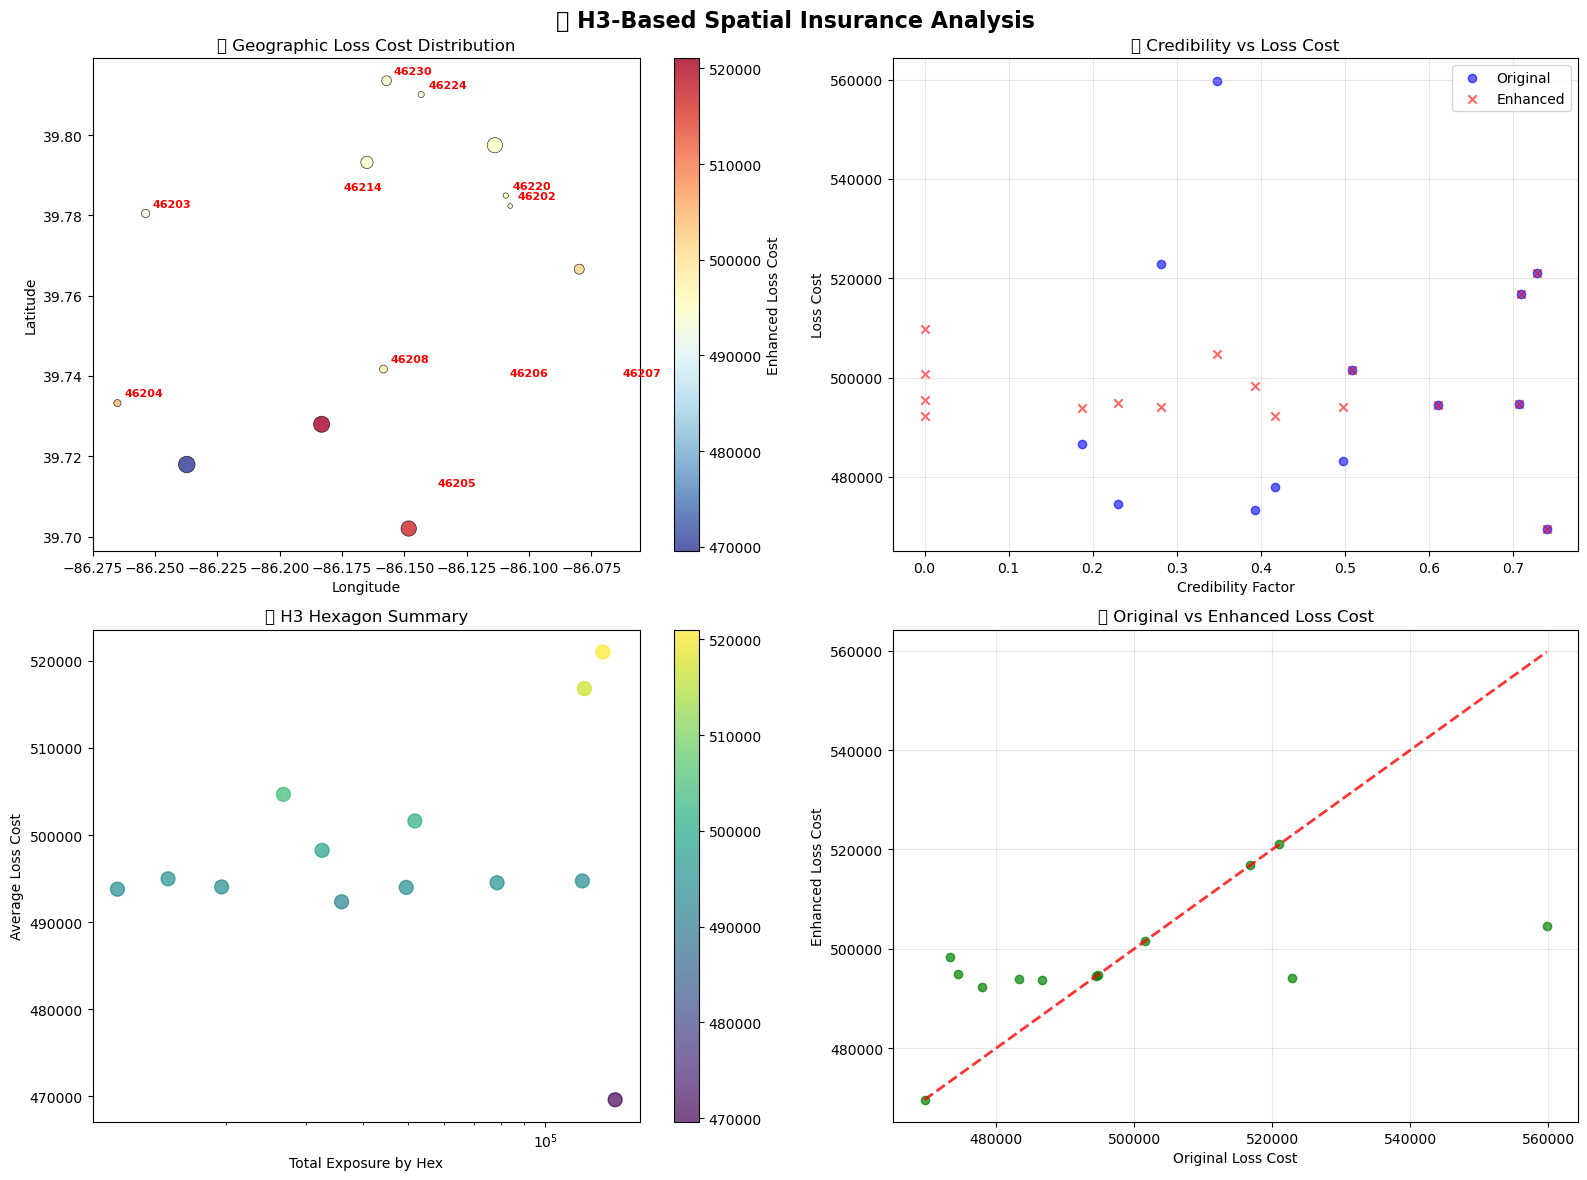


📋 RESULTS SUMMARY
🎯 Target ZIP 46206:
   Exposure: $0
   Original Loss Cost: nan
   Enhanced Loss Cost: $492217.4431
   Credibility: 0.000
   H3 Hex: 882661a2d9fffff

📊 Overall Statistics:
   Average credibility: 0.374
   Low credibility areas: 11/17
   Enhanced loss cost range: $469583.944 - $521038.199

📋 Final Results (Top 10 by Enhanced Loss Cost):
   zip_code     exposure    loss_cost  enhanced_loss_cost  credibility  \
16    46220  133816.5310  521038.1986         521038.1986       0.7280   
8     46209  121918.4033  516827.5894         516827.5894       0.7092   
4     46205       0.0000          NaN         509777.9187       0.0000   
3     46204   26705.1897  559785.1526         504671.4549       0.3482   
14    46225   51836.0645  501615.9688         501615.9688       0.5090   
6     46207       0.0000          NaN         500622.4120       0.0000   
7     46208   32459.3333  473309.3206         498237.0647       0.3936   
10    46214       0.0000          NaN         495518

In [22]:
# Enhanced H3-Based Insurance Credibility & Spatial Analysis
# ==========================================================

# --- 1. Libraries ---
import pandas as pd
import numpy as np
import h3
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("🎯 Enhanced H3-Based Insurance Credibility & Spatial Analysis")
print("=" * 60)

# Check H3 version and set appropriate functions
print(f"H3 version: {h3.__version__}")

# Determine which API to use based on available functions
if hasattr(h3, 'latlng_to_cell'):
    # H3 v4+ API
    geo_to_h3 = h3.latlng_to_cell
    h3_to_geo = h3.cell_to_latlng
    k_ring = h3.grid_ring
    point_dist = lambda p1, p2: h3.great_circle_distance(p1, p2, unit='km')
    print("✅ Using H3 v4+ API")
elif hasattr(h3, 'geo_to_h3'):
    # H3 v3 API
    geo_to_h3 = h3.geo_to_h3
    h3_to_geo = h3.h3_to_geo
    k_ring = h3.k_ring
    point_dist = lambda p1, p2: h3.point_dist(p1, p2, unit='km')
    print("✅ Using H3 v3 API")
else:
    print("❌ H3 API not recognized")
    exit()

# --- 2. Load or Create Sample Data with H3 ---
def create_sample_data_with_h3():
    """Create realistic insurance data with H3 hexagons"""
    np.random.seed(42)
    
    # Indianapolis area coordinates
    base_lat, base_lon = 39.7684, -86.1581
    zip_codes = ['46201', '46202', '46203', '46204', '46205', '46206', '46207', '46208', 
                 '46209', '46210', '46214', '46218', '46220', '46224', '46225', '46230','46220']
    
    data = []
    for i, zip_code in enumerate(zip_codes):
        # Generate coordinates with realistic spread
        lat = base_lat + np.random.normal(0, 0.05)
        lon = base_lon + np.random.normal(0, 0.05)
        
        # Generate H3 hex at resolution 8 (neighborhood level)
        h3_hex = geo_to_h3(lat, lon, 8)
        
        # 15% chance of no exposure (sparse data)
        if np.random.random() < 0.15:
            exposure = 0
            loss_cost = np.nan
        else:
            exposure = np.random.exponential(75000) + 10000
            loss_cost = np.random.gamma(500, 1000) + 200 + np.random.normal(100, 1000)
        
        data.append({
            'zip_code': zip_code,
            'exposure': exposure,
            'loss_cost': loss_cost,
            'latitude': lat,
            'longitude': lon,
            'h3_hex': h3_hex
        })
    
    return pd.DataFrame(data)

# Load data
try:
    df = pd.read_csv("data.csv")
    # Add H3 hexagons if not present
    if 'h3_hex' not in df.columns:
        df['h3_hex'] = df.apply(lambda row: geo_to_h3(row['latitude'], row['longitude'], 8), axis=1)
    print(f"✅ Data loaded: {df.shape[0]} rows")
except:
    df = create_sample_data_with_h3()
    print("⚠️  Created sample data with H3 hexagons")

print("📋 Sample data:")
print(df.head())
print(f"\n🔷 Unique H3 hexagons: {df['h3_hex'].nunique()}")

# --- 3. H3-Based Spatial Analysis ---
class H3SpatialAnalyzer:
    """H3-based spatial analysis for insurance data"""
    
    def __init__(self, resolution=8):
        self.resolution = resolution
        
    def get_hex_neighbors(self, hex_id, k_rings=3):
        """Get neighbors within k rings using H3"""
        neighbors = set()
        for k in range(1, k_rings + 1):
            try:
                neighbors.update(k_ring(hex_id, k))
            except:
                # Fallback for different API versions
                neighbors.update(h3.k_ring(hex_id, k) if hasattr(h3, 'k_ring') else h3.grid_ring(hex_id, k))
        return list(neighbors)
    
    def calculate_hex_distances(self, hex1, hex2):
        """Calculate distance between hexagons in km"""
        lat1, lon1 = h3_to_geo(hex1)
        lat2, lon2 = h3_to_geo(hex2)
        return point_dist((lat1, lon1), (lat2, lon2))
    
    def spatial_interpolation_h3(self, df, target_hex, method='idw', max_neighbors=8):
        """Spatial interpolation using H3 neighbors"""
        
        # Get valid neighbors with data
        neighbors = self.get_hex_neighbors(target_hex, k_rings=5)
        neighbor_data = df[df['h3_hex'].isin(neighbors) & (df['exposure'] > 0)].copy()
        
        if len(neighbor_data) == 0:
            return df['loss_cost'].mean()  # Fallback to overall mean
        
        # Calculate distances and weights
        neighbor_data['distance'] = neighbor_data['h3_hex'].apply(
            lambda x: self.calculate_hex_distances(target_hex, x)
        )
        
        # Sort by distance and take closest neighbors
        neighbor_data = neighbor_data.nsmallest(max_neighbors, 'distance')
        
        if method == 'idw':
            # Inverse Distance Weighting
            weights = 1 / (neighbor_data['distance'] + 0.1) ** 2
            weights = weights / weights.sum()
            return np.dot(neighbor_data['loss_cost'], weights)
        
        elif method == 'exposure_weighted':
            # Weight by both distance and exposure
            dist_weights = 1 / (neighbor_data['distance'] + 0.1)
            exp_weights = neighbor_data['exposure'] / neighbor_data['exposure'].sum()
            combined_weights = dist_weights * exp_weights
            combined_weights = combined_weights / combined_weights.sum()
            return np.dot(neighbor_data['loss_cost'], combined_weights)

# Initialize H3 analyzer
h3_analyzer = H3SpatialAnalyzer()

# --- 4. Enhanced Credibility with H3 Context ---
MIN_EXPOSURE = 50000

def enhanced_credibility_adjustment(df):
    """Enhanced credibility adjustment using H3 spatial context"""
    
    # Calculate overall loss cost (exposure-weighted)
    valid_data = df.dropna(subset=['loss_cost'])
    overall_loss_cost = np.average(valid_data['loss_cost'], weights=valid_data['exposure'])
    
    # Calculate hex-level aggregations
    hex_stats = df.groupby('h3_hex').agg({
        'exposure': 'sum',
        'loss_cost': lambda x: x.dropna().mean() if len(x.dropna()) > 0 else np.nan
    }).reset_index()
    
    # Calculate credibility factors
    df['credibility'] = df['exposure'].apply(lambda x: x / (x + MIN_EXPOSURE))
    
    # Apply spatial interpolation for low credibility areas
    df['enhanced_loss_cost'] = df['loss_cost'].copy()
    
    low_cred_mask = (df['credibility'] < 0.5) | df['loss_cost'].isna()
    
    for idx, row in df[low_cred_mask].iterrows():
        spatial_estimate = h3_analyzer.spatial_interpolation_h3(
            df, row['h3_hex'], method='exposure_weighted'
        )
        
        # Blend credibility and spatial estimates
        credibility_estimate = row['credibility'] * row['loss_cost'] if not pd.isna(row['loss_cost']) else 0
        credibility_estimate += (1 - row['credibility']) * overall_loss_cost
        
        # Final estimate (weighted average of credibility and spatial)
        spatial_weight = 0.7 if row['credibility'] < 0.3 else 0.3
        final_estimate = (spatial_weight * spatial_estimate + 
                         (1 - spatial_weight) * credibility_estimate)
        
        df.loc[idx, 'enhanced_loss_cost'] = final_estimate
    
    return df, overall_loss_cost

# Apply enhanced credibility adjustment
df, overall_loss_cost = enhanced_credibility_adjustment(df)

print(f"\n✅ Enhanced credibility adjustment complete")
print(f"   📊 Overall loss cost: ${overall_loss_cost:.4f}")
print(f"   📊 Areas needing interpolation: {(df['credibility'] < 0.5).sum()}")

# --- 5. H3 Visualization ---
def plot_h3_analysis(df):
    """Create H3-based visualizations"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔷 H3-Based Spatial Insurance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Geographic distribution with H3
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df['longitude'], df['latitude'], 
                         c=df['enhanced_loss_cost'], s=df['exposure']/1000,
                         cmap='RdYlBu_r', alpha=0.8, edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('🗺️ Geographic Loss Cost Distribution')
    plt.colorbar(scatter, ax=ax1, label='Enhanced Loss Cost')
    
    # Add ZIP code labels
    for _, row in df.iterrows():
        if row['credibility'] < 0.5:  # Highlight low credibility areas
            ax1.annotate(row['zip_code'], (row['longitude'], row['latitude']),
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, color='red', weight='bold')
    
    # 2. Credibility vs Enhancement
    ax2 = axes[0, 1]
    valid_original = df.dropna(subset=['loss_cost'])
    ax2.scatter(valid_original['credibility'], valid_original['loss_cost'], 
               alpha=0.6, label='Original', color='blue')
    ax2.scatter(df['credibility'], df['enhanced_loss_cost'], 
               alpha=0.6, label='Enhanced', color='red', marker='x')
    ax2.set_xlabel('Credibility Factor')
    ax2.set_ylabel('Loss Cost')
    ax2.set_title('🎯 Credibility vs Loss Cost')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. H3 Hexagon Analysis
    ax3 = axes[1, 0]
    hex_summary = df.groupby('h3_hex').agg({
        'exposure': 'sum',
        'enhanced_loss_cost': 'mean',
        'zip_code': 'count'
    }).reset_index()
    hex_summary.columns = ['h3_hex', 'total_exposure', 'avg_loss_cost', 'zip_count']
    
    scatter = ax3.scatter(hex_summary['total_exposure'], hex_summary['avg_loss_cost'],
                         s=hex_summary['zip_count']*100, alpha=0.7, 
                         c=hex_summary['avg_loss_cost'], cmap='viridis')
    ax3.set_xlabel('Total Exposure by Hex')
    ax3.set_ylabel('Average Loss Cost')
    ax3.set_title('🔷 H3 Hexagon Summary')
    ax3.set_xscale('log')
    plt.colorbar(scatter, ax=ax3)
    
    # 4. Before vs After Enhancement
    ax4 = axes[1, 1]
    valid_data = df.dropna(subset=['loss_cost'])
    ax4.scatter(valid_data['loss_cost'], valid_data['enhanced_loss_cost'], 
               alpha=0.7, color='green')
    
    # Add perfect correlation line
    min_val = min(valid_data['loss_cost'].min(), df['enhanced_loss_cost'].min())
    max_val = max(valid_data['loss_cost'].max(), df['enhanced_loss_cost'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    
    ax4.set_xlabel('Original Loss Cost')
    ax4.set_ylabel('Enhanced Loss Cost')
    ax4.set_title('📊 Original vs Enhanced Loss Cost')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
print("\n📊 Creating H3-based visualizations...")
plot_h3_analysis(df)

# --- 6. Results Summary ---
print(f"\n📋 RESULTS SUMMARY")
print("=" * 30)

# Show specific examples
target_zip = "46206"  # Your original target
target_data = df[df['zip_code'] == target_zip]

if len(target_data) > 0:
    target_row = target_data.iloc[0]
    print(f"🎯 Target ZIP {target_zip}:")
    print(f"   Exposure: ${target_row['exposure']:,.0f}")
    print(f"   Original Loss Cost: {target_row['loss_cost']}")
    print(f"   Enhanced Loss Cost: ${target_row['enhanced_loss_cost']:.4f}")
    print(f"   Credibility: {target_row['credibility']:.3f}")
    print(f"   H3 Hex: {target_row['h3_hex']}")

# Overall statistics
print(f"\n📊 Overall Statistics:")
print(f"   Average credibility: {df['credibility'].mean():.3f}")
print(f"   Low credibility areas: {(df['credibility'] < 0.5).sum()}/{len(df)}")
print(f"   Enhanced loss cost range: ${df['enhanced_loss_cost'].min():.3f} - ${df['enhanced_loss_cost'].max():.3f}")

# Show final results
print(f"\n📋 Final Results (Top 10 by Enhanced Loss Cost):")
result_cols = ['zip_code', 'exposure', 'loss_cost', 'enhanced_loss_cost', 'credibility', 'h3_hex']
print(df[result_cols].nlargest(10, 'enhanced_loss_cost').round(4))